In [348]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from pathlib import Path

In [349]:
wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_ChipSeq/custom_pipeline'
os.chdir(wd_dir)

# Get the current working directory
current_dir = os.getcwd()

In [350]:
def filter_standard_chromosomes(input_file, output_file):
    """
    Filter BED file to keep only standard chromosomes (chr1-chr22, chrX, chrY, chrM)
    """
    # Count total peaks
    total = subprocess.run(f"wc -l {input_file}", shell=True, capture_output=True, text=True)
    total = int(total.stdout.split()[0])
    
    # Filter and count remaining peaks
    cmd = f"grep -P '^chr([1-9]|1[0-9]|2[0-2]|X|Y|M)\t' {input_file} > {output_file}"
    subprocess.run(cmd, shell=True)
    
    filtered = subprocess.run(f"wc -l {output_file}", shell=True, capture_output=True, text=True)
    filtered = int(filtered.stdout.split()[0])
    
    print(f"Filtered {input_file}: kept {filtered}/{total} peaks ({filtered/total*100:.1f}%)")

In [351]:
def calculate_peak_cpg_coverage_exact(peak_file, cpg_file):
    """
    Calculate what percentage of each peak overlaps with CpG islands
    """
    # Use bedtools intersect to find overlaps
    cmd = f"bedtools intersect -a {peak_file} -b {cpg_file} -wao"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    # Parse the output
    overlaps = []
    for line in result.stdout.strip().split('\n'):
        fields = line.split('\t')
        if len(fields) >= 13:  # Ensure we have enough fields
            # peak_length = int(fields[2]) - int(fields[1])
            cpg_length = abs(int(fields[2]) - int(fields[1]))
            overlap_length = int(fields[-1])
            if cpg_length > 0:
                coverage_percent = (overlap_length / cpg_length) * 100
                overlaps.append(coverage_percent)
    
    return overlaps

In [354]:
def calculate_peak_cpg_coverage(peak_file, cpg_file, extend):
    """
    Calculate what percentage of each peak overlaps with CpG islands
    CpG islands are extended by 300bp on each side
    """
    # First extend CpG islands by 300bp on each side
    # Create a temporary extended CpG file
    cmd_extend = f"bedtools slop -i {cpg_file} -g DATA/genome.size -b {extend} > temp_extended_cpg.bed"
    subprocess.run(cmd_extend, shell=True)
    
    # Use bedtools intersect with extended CpG islands
    cmd = f"bedtools intersect -a {peak_file} -b temp_extended_cpg.bed -wao"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    # Clean up temporary file
    subprocess.run("rm temp_extended_cpg.bed", shell=True)
    
    # Parse the output
    overlaps = []
    for line in result.stdout.strip().split('\n'):
        fields = line.split('\t')
        if len(fields) >= 13:  # Ensure we have enough fields
            cpg_length = abs(int(fields[2]) - int(fields[1]))  # CpG island length
            overlap_length = int(fields[-1])
            if cpg_length > 0:
                coverage_percent = (overlap_length / cpg_length) * 100
                overlaps.append(coverage_percent)
    
    return overlaps

In [355]:
def plot_coverage_histograms(exo_coverage, endo_coverage, min_coverage=0, max_coverage=100):
    """
    Create histograms for both types of coverage in separate subplots
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Filter out zeros and 100% coverage values
    exo_nonzero = [x for x in exo_coverage if x > min_coverage and x < max_coverage]
    endo_nonzero = [x for x in endo_coverage if x > min_coverage and x < max_coverage]
    
    # Exogenous plot
    ax1.hist(exo_nonzero, bins=50, color='blue', density=True)
    ax1.set_xlabel('CpG Island Coverage (%)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Exogenous Peaks')
    
    # Add exogenous summary statistics
    exo_mean = sum(x > 0 for x in exo_coverage) / len(exo_coverage) * 100
    ax1.text(0.02, 0.98,
             f'Peaks with CpG: {exo_mean:.1f}%',
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Endogenous plot  
    ax2.hist(endo_nonzero, bins=50, color='red', density=True)
    ax2.set_xlabel('CpG Island Coverage (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Endogenous Peaks')
    
    # Add endogenous summary statistics
    endo_mean = sum(x > 80 for x in endo_coverage) / len(endo_coverage) * 100
    ax2.text(0.02, 0.98,
             f'Peaks with CpG: {endo_mean:.1f}%',
             transform=ax2.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # plt.savefig('cpg_coverage_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [377]:
def plot_coverage_histograms_by_count(exo_coverage, endo_coverage, min_coverage=0, max_coverage=100):
    """
    Create histograms for both types of coverage in separate subplots
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Filter out zeros and 100% coverage values
    exo_nonzero = [x for x in exo_coverage if x > min_coverage and x < max_coverage]
    endo_nonzero = [x for x in endo_coverage if x > min_coverage and x < max_coverage]
    
    # Exogenous plot
    ax1.hist(exo_nonzero, bins=50, color='blue')
    ax1.set_xlabel('CpG Island Coverage (%)')
    ax1.set_ylabel('Number of Peaks')
    ax1.set_title('Exogenous Peaks')
    
    # Add exogenous summary statistics
    exo_mean = sum(x > 0 for x in exo_coverage) / len(exo_coverage) * 100
    ax1.text(0.02, 0.98,
             f'Peaks with CpG: {exo_mean:.1f}%',
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Endogenous plot  
    ax2.hist(endo_nonzero, bins=50, color='red')
    ax2.set_xlabel('CpG Island Coverage (%)')
    ax2.set_ylabel('Number of Peaks')
    ax2.set_title('Endogenous Peaks')
    
    # Add endogenous summary statistics
    prc_t = 80
    endo_mean = sum(x > prc_t for x in endo_coverage) / len(endo_coverage) * 100
    ax2.text(0.02, 0.98,
             f'Peaks with CpG (>{prc_t}%): {endo_mean:.1f}%',
             transform=ax2.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # plt.savefig('cpg_coverage_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


# All cpg islands

In [378]:
# Path to your CpG islands file (you'll need to provide this)
cpg_file = "DATA/cpg_islands.bed"

# Get all peak files for each condition
results_dir = Path("results/peaks")

# Read sample sheets to get the peak files
exo_samples = pd.read_csv("DATA/EXOGENOUS_sample_sheet.csv")
endo_samples = pd.read_csv("DATA/ENDOGENOUS_sample_sheet.csv")


# Filter for NEU samples only
exo_samples = exo_samples[exo_samples['Tissue'] == 'NSC']
endo_samples = endo_samples[
    (endo_samples['Tissue'] == 'NSC') & 
    (endo_samples['Factor'] != 'IgG')
]

# Filter out control samples
endo_samples = endo_samples[endo_samples['Factor'] != 'IgG']

In [379]:
# Read cpg_file
cpg_df = pd.read_csv(cpg_file, sep='\t', header=None)
cpg_df.head()

,0,1,2,3,4,5
0,chr1,3531624,3531843,611,CpG:,27
1,chr1,3670619,3671074,613,CpG:,34
2,chr1,3671654,3672156,613,CpG:,45
3,chr1,4491701,4493673,619,CpG:,165
4,chr1,4496947,4497608,619,CpG:,47


In [380]:
exo_coverage = []
for peak_file in exo_samples['Peaks']:
    # Create temporary filtered peak file
    temp_peak = "temp_filtered_peaks.bed"
    filter_standard_chromosomes(peak_file, temp_peak)
    
    # Calculate coverage using filtered peaks
    coverage = calculate_peak_cpg_coverage(temp_peak, cpg_file, extend=100)
    exo_coverage.extend(coverage)
    
    # Clean up
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 17480/17536 peaks (99.7%)
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 21347/21437 peaks (99.6%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 15644/15676 peaks (99.8%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [381]:
exo_coverage[:10]

[0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0]

In [382]:
endo_coverage = []
for peak_file in endo_samples['Peaks']:
    # Create temporary filtered peak file
    temp_peak = "temp_filtered_peaks.bed"
    filter_standard_chromosomes(peak_file, temp_peak)
    
    # Calculate coverage using filtered peaks
    coverage = calculate_peak_cpg_coverage(temp_peak, cpg_file, extend=100)
    endo_coverage.extend(coverage)
    
    # Clean up
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 68872/68939 peaks (99.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 28028/28061 peaks (99.9%)
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 19396/19419 peaks (99.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [383]:
endo_coverage[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 79.23728813559322, 0.0, 0.0, 0.0, 0.0]

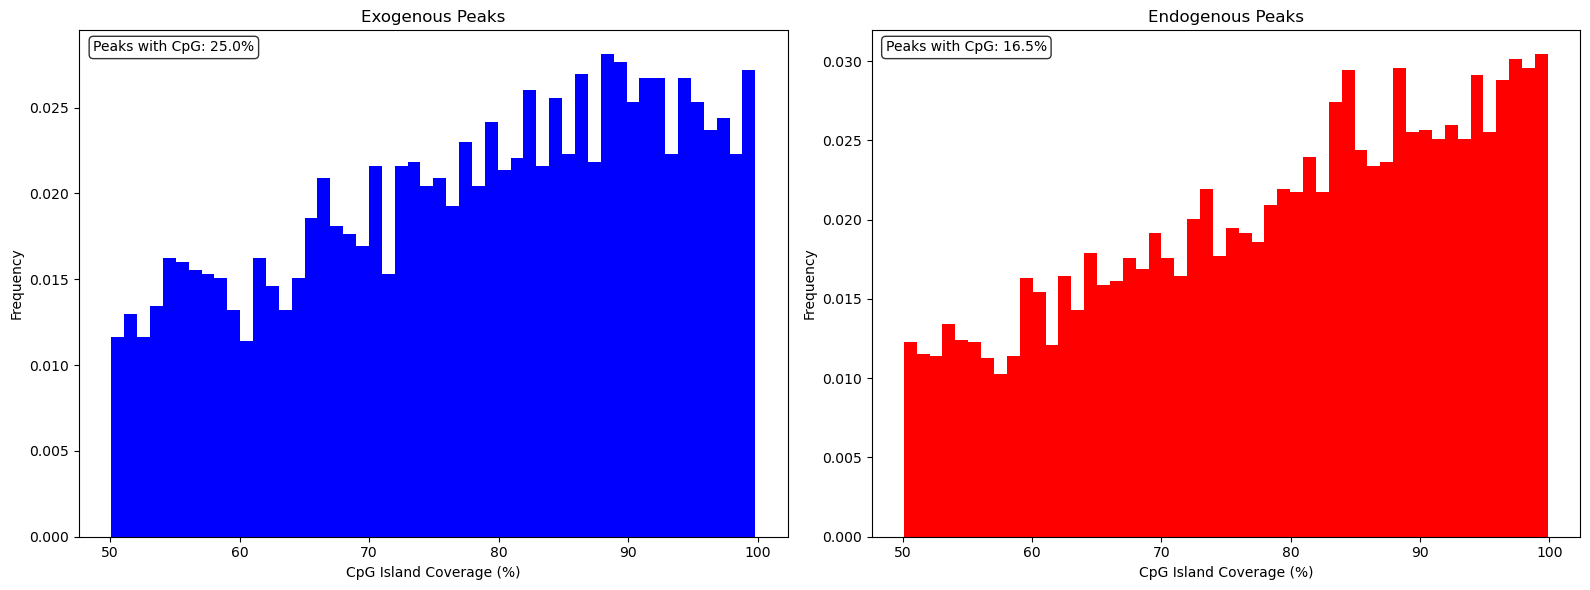

In [384]:
# Create the visualization
plot_coverage_histograms(exo_coverage, endo_coverage, min_coverage=50)

# Only with the common peaks

In [364]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from pathlib import Path
import mygene

def convert_symbols_to_ensembl(gene_symbols):
    """Convert gene symbols to Ensembl IDs"""
    mg = mygene.MyGeneInfo()
    results = mg.querymany(gene_symbols, scopes='symbol', fields='ensembl.gene', species='mouse')
    
    # Create mapping dictionary
    id_map = {}
    for r in results:
        if 'ensembl' in r:
            if isinstance(r['ensembl'], list):
                # Take the first ensembl ID if there are multiple
                id_map[r['query']] = r['ensembl'][0]['gene']
            else:
                id_map[r['query']] = r['ensembl']['gene']
    return id_map

def get_common_peaks(peak_file, common_genes, genome):
    """
    Filter peaks to keep only those associated with genes that have both 
    Endogenous and Exogenous promoters
    """
    # Create temporary files
    temp_genes = "temp_common_genes.bed"
    temp_out = "temp_filtered_peaks.bed"
    
    # Convert gene symbols to Ensembl IDs
    ensembl_ids = convert_symbols_to_ensembl(common_genes['gene'].tolist())
    print(f"Converted {len(ensembl_ids)} genes to Ensembl IDs")
    
    # Create pattern for grep
    pattern = '|'.join(ensembl_ids.values())
    
    # Extract relevant genes from genome file
    with open(temp_genes, 'w') as f:
        cmd = f"grep -E '{pattern}' {genome}"
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        f.write(result.stdout)
    
    # Add 2kb upstream and downstream to include promoter regions
    cmd_extend = f"bedtools slop -i {temp_genes} -g DATA/genome.size -b 2000 > temp_extended_genes.bed"
    subprocess.run(cmd_extend, shell=True)
    
    # Intersect peaks with extended gene regions
    cmd2 = f"bedtools intersect -a {peak_file} -b temp_extended_genes.bed -wa | sort | uniq > {temp_out}"
    subprocess.run(cmd2, shell=True)
    
    # Count peaks for logging
    result_total = subprocess.run(f"wc -l {peak_file}", shell=True, capture_output=True, text=True)
    total_peaks = int(result_total.stdout.split()[0])
    
    result_filtered = subprocess.run(f"wc -l {temp_out}", shell=True, capture_output=True, text=True)
    filtered_peaks = int(result_filtered.stdout.split()[0])
    
    print(f"Filtered {peak_file}: kept {filtered_peaks}/{total_peaks} peaks ({filtered_peaks/total_peaks*100:.1f}%)")
    
    # Clean up intermediate files
    subprocess.run("rm temp_common_genes.bed temp_extended_genes.bed", shell=True)
    
    return temp_out

def calculate_peak_cpg_coverage(peak_file, cpg_file, extend=300):
    """
    Calculate what percentage of each peak overlaps with CpG islands
    CpG islands are extended by 300bp on each side
    """
    # First extend CpG islands by 300bp on each side
    cmd_extend = f"bedtools slop -i {cpg_file} -g DATA/genome.size -b {extend} > temp_extended_cpg.bed"
    subprocess.run(cmd_extend, shell=True)
    
    # Use bedtools intersect with extended CpG islands
    cmd = f"bedtools intersect -a {peak_file} -b temp_extended_cpg.bed -wao"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    # Clean up temporary file
    subprocess.run("rm temp_extended_cpg.bed", shell=True)
    
    # Parse the output
    overlaps = []
    for line in result.stdout.strip().split('\n'):
        fields = line.split('\t')
        if len(fields) >= 13:  # Ensure we have enough fields
            cpg_length = abs(int(fields[2]) - int(fields[1]))
            overlap_length = int(fields[-1])
            if cpg_length > 0:
                coverage_percent = (overlap_length / cpg_length) * 100
                overlaps.append(coverage_percent)
    
    return overlaps

In [365]:
# Read the gene list
genes_df = pd.read_csv("DATA/allgenes_NEU_total.csv")

# Filter for genes that have both types of promoters
common_genes = genes_df[
    (genes_df['Endogenous_Promoter'] == True) & 
    (genes_df['Exogenous_Promoter'] == True)
]
print(f"Number of genes with both promoter types: {len(common_genes)}")
print("Example genes:", common_genes['gene'].head().tolist())

Number of genes with both promoter types: 285
Example genes: ['Abcc4', 'Adamts10', 'Adamtsl2', 'Adgrl2', 'Adrb1']


In [366]:
common_genes.head()

,gene,baseMean,log2FoldChange,Direction,Endogenous_Promoter,Exogenous_Promoter
0,Abcc4,206.795391,-0.595743,DOWN,True,True
2,Adamts10,501.333702,0.901479,UP,True,True
3,Adamtsl2,252.788651,0.501510,UP,True,True
4,Adgrl2,2101.578603,-1.044162,DOWN,True,True
5,Adrb1,279.618996,-0.604688,DOWN,True,True


In [367]:
# Read sample sheets
exo_samples = pd.read_csv("DATA/EXOGENOUS_sample_sheet.csv")
endo_samples = pd.read_csv("DATA/ENDOGENOUS_sample_sheet.csv")

# Filter for NEU samples only
exo_samples = exo_samples[exo_samples['Tissue'] == 'NSC']
endo_samples = endo_samples[
    (endo_samples['Tissue'] == 'NSC') & 
    (endo_samples['Factor'] != 'IgG')
]

In [368]:
cpg_file = "DATA/cpg_islands.bed"  # Make sure this exists

In [369]:
# Calculate coverage for filtered peaks
exo_coverage = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, common_genes, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

1 input query terms found no hit:	['Rnf165']
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Converted 284 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 552/17536 peaks (3.1%)


1 input query terms found no hit:	['Rnf165']
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Converted 284 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 667/21437 peaks (3.1%)


1 input query terms found no hit:	['Rnf165']


Converted 284 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 525/15676 peaks (3.3%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [370]:
exo_coverage[:10]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0]

In [371]:
endo_coverage = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, common_genes, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file)
    endo_coverage.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

1 input query terms found no hit:	['Rnf165']
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Converted 284 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 1913/68939 peaks (2.8%)


1 input query terms found no hit:	['Rnf165']
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Converted 284 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 796/28061 peaks (2.8%)


1 input query terms found no hit:	['Rnf165']


Converted 284 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 543/19419 peaks (2.8%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


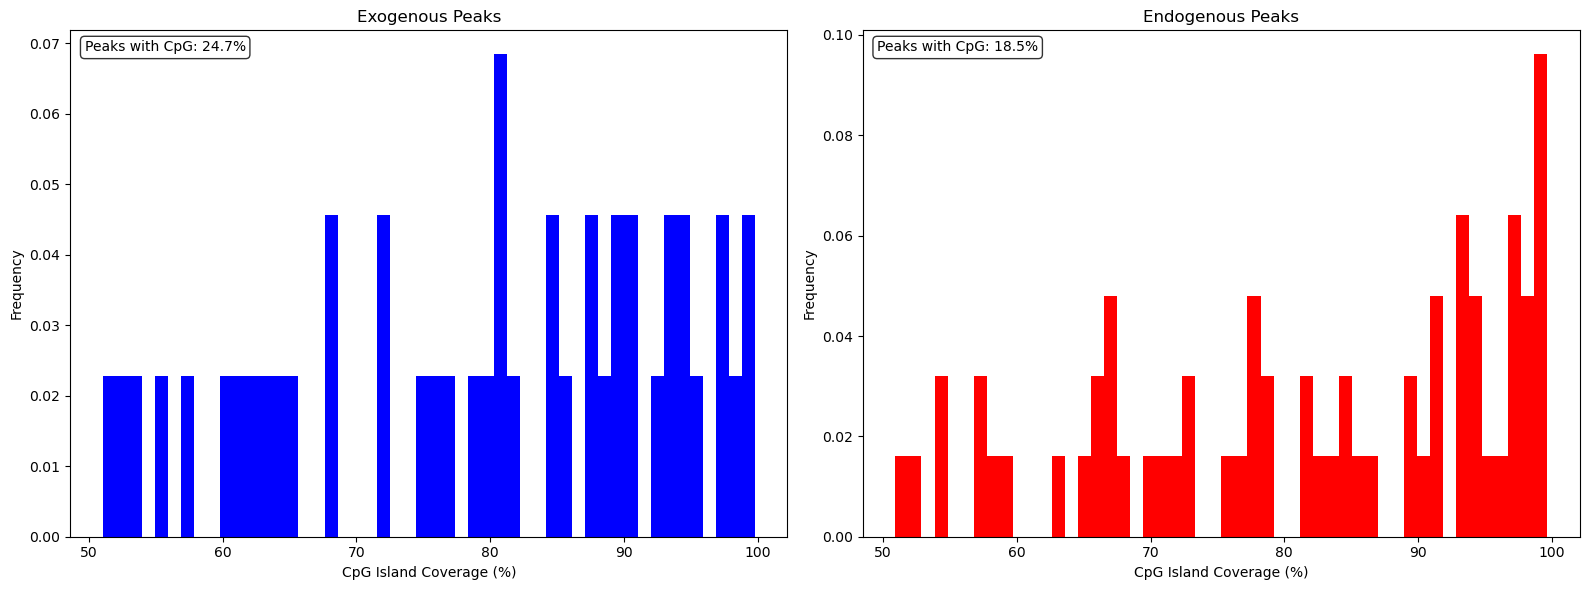

In [376]:
# Create the visualization
plot_coverage_histograms(exo_coverage, endo_coverage, min_coverage=50)

# DE expression bins

# UP

In [385]:
DEA_NEU = pd.read_csv("./DATA/DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("./DATA/DEA_NSC.csv", header=0)

In [421]:
DEA_NSC.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,expression_level
5337,Top2b,13465.464930,-0.129776,0.055509,-2.337916,0.019392,0.049904,High
5338,Zfp113,974.648226,-0.204025,0.087200,-2.339752,0.019297,0.049670,Medium
5339,Gm48768,125.444070,0.475061,0.202973,2.340507,0.019258,0.049583,Low
5340,Pfkm,2126.364649,0.232159,0.099092,2.342858,0.019137,0.049290,High
5341,Syde2,306.400724,-0.346175,0.147748,-2.343007,0.019129,0.049280,Low


In [422]:
DEA_NEU = DEA_NEU[DEA_NEU['padj'] < 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['padj'] < 0.05]

In [423]:
DEA_NSC = DEA_NSC[DEA_NSC['log2FoldChange'] > 0]
DEA_NEU = DEA_NEU[DEA_NEU['log2FoldChange'] > 0]

In [424]:
# Calculate quantiles for expression binning
q33, q66 = DEA_NSC['baseMean'].quantile([0.33, 0.66])

In [425]:
# Create a function to assign expression level
def get_expression_level(baseMean):
    if baseMean <= q33:
        return 'Low'
    elif baseMean <= q66:
        return 'Medium'
    else:
        return 'High'

In [426]:
# Add expression level column to DEA_NSC
DEA_NSC['expression_level'] = DEA_NSC['baseMean'].apply(get_expression_level)

In [427]:
# Let's see the distribution
print("Expression level boundaries:")
print(f"Low: baseMean <= {q33:.2f}")
print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
print(f"High: baseMean > {q66:.2f}")
print("\nNumber of genes in each category:")
print(DEA_NSC['expression_level'].value_counts())

Expression level boundaries:
Low: baseMean <= 388.43
Medium: 388.43 < baseMean <= 1537.49
High: baseMean > 1537.49

Number of genes in each category:
expression_level
High      1437
Low       1394
Medium    1394
Name: count, dtype: int64


In [428]:
DEA_NSC.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,expression_level
5339,Gm48768,125.444070,0.475061,0.202973,2.340507,0.019258,0.049583,Low
5340,Pfkm,2126.364649,0.232159,0.099092,2.342858,0.019137,0.049290,High
5342,Fam8a1,3567.752059,0.170360,0.072699,2.343368,0.019111,0.049237,High
5345,Gm16523,144.400618,0.420394,0.179285,2.344842,0.019035,0.049057,Low
5346,Itgbl1,211.612347,0.436382,0.186093,2.344966,0.019029,0.049046,Low


In [429]:
DEA_NSC_high = DEA_NSC[DEA_NSC.expression_level == 'High']
DEA_NSC_medium = DEA_NSC[DEA_NSC.expression_level == 'Medium']
DEA_NSC_low = DEA_NSC[DEA_NSC.expression_level == 'Low']

In [430]:
# Calculate coverage for filtered peaks
exo_coverage_high = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

1 input query terms found dup hits:	[('Gm42047', 2)]
26 input query terms found no hit:	['Slc9a3r1', '9930021J03Rik', 'Wars', 'C330007P06Rik', 'Ick', '1810013L24Rik', '2900097C17Rik', 'Mar


Converted 1411 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 2185/17536 peaks (12.5%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
1 input query terms found dup hits:	[('Gm42047', 2)]
26 input query terms found no hit:	['Slc9a3r1', '9930021J03Rik', 'Wars', 'C330007P06Rik', 'Ick', '1810013L24Rik', '2900097C17Rik', 'Mar


Converted 1411 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 2675/21437 peaks (12.5%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
1 input query terms found dup hits:	[('Gm42047', 2)]
26 input query terms found no hit:	['Slc9a3r1', '9930021J03Rik', 'Wars', 'C330007P06Rik', 'Ick', '1810013L24Rik', '2900097C17Rik', 'Mar


Converted 1411 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 2039/15676 peaks (13.0%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [431]:
# Calculate coverage for filtered peaks
exo_coverage_medium = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

20 input query terms found dup hits:	[('Arhgap26', 2), ('Zfp862-ps', 2), ('5830417I10Rik', 2), ('Gm7292', 2), ('8030445P17Rik', 2), ('Gm5
33 input query terms found no hit:	['5930412G12Rik', 'BC030867', 'Gm10125', 'Tmem173', 'Gm26603', 'Map11', '2410131K14Rik', '9330182L06


Converted 1361 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 1632/17536 peaks (9.3%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
20 input query terms found dup hits:	[('Arhgap26', 2), ('Zfp862-ps', 2), ('5830417I10Rik', 2), ('Gm7292', 2), ('8030445P17Rik', 2), ('Gm5
33 input query terms found no hit:	['5930412G12Rik', 'BC030867', 'Gm10125', 'Tmem173', 'Gm26603', 'Map11', '2410131K14Rik', '9330182L06


Converted 1361 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 1997/21437 peaks (9.3%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
20 input query terms found dup hits:	[('Arhgap26', 2), ('Zfp862-ps', 2), ('5830417I10Rik', 2), ('Gm7292', 2), ('8030445P17Rik', 2), ('Gm5
33 input query terms found no hit:	['5930412G12Rik', 'BC030867', 'Gm10125', 'Tmem173', 'Gm26603', 'Map11', '2410131K14Rik', '9330182L06


Converted 1361 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 1504/15676 peaks (9.6%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [432]:
# Calculate coverage for filtered peaks
exo_coverage_low = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

116 input query terms found dup hits:	[('Gm16523', 2), ('Gm36501', 2), ('Gm17494', 2), ('Bcas1os1', 2), ('Pisd-ps2', 2), ('A930015D03Rik',
62 input query terms found no hit:	['AC125544.1', 'AC140469.1', 'Lrrc29', 'AC166172.3', 'Gm26809', '5430403G16Rik', 'Ccdc151', 'Gm26835


Converted 1330 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 973/17536 peaks (5.5%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
116 input query terms found dup hits:	[('Gm16523', 2), ('Gm36501', 2), ('Gm17494', 2), ('Bcas1os1', 2), ('Pisd-ps2', 2), ('A930015D03Rik',
62 input query terms found no hit:	['AC125544.1', 'AC140469.1', 'Lrrc29', 'AC166172.3', 'Gm26809', '5430403G16Rik', 'Ccdc151', 'Gm26835


Converted 1330 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 1146/21437 peaks (5.3%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
116 input query terms found dup hits:	[('Gm16523', 2), ('Gm36501', 2), ('Gm17494', 2), ('Bcas1os1', 2), ('Pisd-ps2', 2), ('A930015D03Rik',
62 input query terms found no hit:	['AC125544.1', 'AC140469.1', 'Lrrc29', 'AC166172.3', 'Gm26809', '5430403G16Rik', 'Ccdc151', 'Gm26835


Converted 1330 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 885/15676 peaks (5.6%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [433]:
# Calculate coverage for filtered peaks
endo_coverage_high = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_medium = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_low = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


1 input query terms found dup hits:	[('Gm42047', 2)]
26 input query terms found no hit:	['Slc9a3r1', '9930021J03Rik', 'Wars', 'C330007P06Rik', 'Ick', '1810013L24Rik', '2900097C17Rik', 'Mar


Converted 1411 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 8248/68939 peaks (12.0%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
1 input query terms found dup hits:	[('Gm42047', 2)]
26 input query terms found no hit:	['Slc9a3r1', '9930021J03Rik', 'Wars', 'C330007P06Rik', 'Ick', '1810013L24Rik', '2900097C17Rik', 'Mar


Converted 1411 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 3724/28061 peaks (13.3%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
1 input query terms found dup hits:	[('Gm42047', 2)]
26 input query terms found no hit:	['Slc9a3r1', '9930021J03Rik', 'Wars', 'C330007P06Rik', 'Ick', '1810013L24Rik', '2900097C17Rik', 'Mar


Converted 1411 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 2549/19419 peaks (13.1%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
20 input query terms found dup hits:	[('Arhgap26', 2), ('Zfp862-ps', 2), ('5830417I10Rik', 2), ('Gm7292', 2), ('8030445P17Rik', 2), ('Gm5
33 input query terms found no hit:	['5930412G12Rik', 'BC030867', 'Gm10125', 'Tmem173', 'Gm26603', 'Map11', '2410131K14Rik', '9330182L06


Converted 1361 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 6096/68939 peaks (8.8%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
20 input query terms found dup hits:	[('Arhgap26', 2), ('Zfp862-ps', 2), ('5830417I10Rik', 2), ('Gm7292', 2), ('8030445P17Rik', 2), ('Gm5
33 input query terms found no hit:	['5930412G12Rik', 'BC030867', 'Gm10125', 'Tmem173', 'Gm26603', 'Map11', '2410131K14Rik', '9330182L06


Converted 1361 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 2769/28061 peaks (9.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
20 input query terms found dup hits:	[('Arhgap26', 2), ('Zfp862-ps', 2), ('5830417I10Rik', 2), ('Gm7292', 2), ('8030445P17Rik', 2), ('Gm5
33 input query terms found no hit:	['5930412G12Rik', 'BC030867', 'Gm10125', 'Tmem173', 'Gm26603', 'Map11', '2410131K14Rik', '9330182L06


Converted 1361 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 1906/19419 peaks (9.8%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
116 input query terms found dup hits:	[('Gm16523', 2), ('Gm36501', 2), ('Gm17494', 2), ('Bcas1os1', 2), ('Pisd-ps2', 2), ('A930015D03Rik',
62 input query terms found no hit:	['AC125544.1', 'AC140469.1', 'Lrrc29', 'AC166172.3', 'Gm26809', '5430403G16Rik', 'Ccdc151', 'Gm26835


Converted 1330 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 3734/68939 peaks (5.4%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
116 input query terms found dup hits:	[('Gm16523', 2), ('Gm36501', 2), ('Gm17494', 2), ('Bcas1os1', 2), ('Pisd-ps2', 2), ('A930015D03Rik',
62 input query terms found no hit:	['AC125544.1', 'AC140469.1', 'Lrrc29', 'AC166172.3', 'Gm26809', '5430403G16Rik', 'Ccdc151', 'Gm26835


Converted 1330 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 1598/28061 peaks (5.7%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
116 input query terms found dup hits:	[('Gm16523', 2), ('Gm36501', 2), ('Gm17494', 2), ('Bcas1os1', 2), ('Pisd-ps2', 2), ('A930015D03Rik',
62 input query terms found no hit:	['AC125544.1', 'AC140469.1', 'Lrrc29', 'AC166172.3', 'Gm26809', '5430403G16Rik', 'Ccdc151', 'Gm26835


Converted 1330 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 1068/19419 peaks (5.5%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [434]:
def plot_coverage_histograms(high, medium, low, min_coverage=0, max_coverage=100, p_t = 80):
    """
    Create histograms for both types of coverage in separate subplots
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
    
    # Filter out zeros and 100% coverage values
    nonzero_high = [x for x in high if x > min_coverage and x < max_coverage]
    nonzero_medium = [x for x in medium if x > min_coverage and x < max_coverage]
    nonzero_low = [x for x in low if x > min_coverage and x < max_coverage]
    
    # High expression
    ax1.hist(nonzero_high, bins=50, color='blue', density=True)
    ax1.set_xlabel('CpG Island Coverage (%)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('High Expression')
    
    # Add exogenous summary statistics
    exo_mean = sum(x > p_t for x in nonzero_high) / len(nonzero_high) * 100
    ax1.text(0.02, 0.98,
             f'Peaks with CpG (>{p_t}%): {exo_mean:.1f}% \ntotal peaks: {len(nonzero_high)}',
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Medium expression
    ax2.hist(nonzero_medium, bins=50, color='red', density=True)
    ax2.set_xlabel('CpG Island Coverage (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Medium Expression')
    
    # Add endogenous summary statistics
    endo_mean = sum(x > p_t for x in nonzero_medium) / len(nonzero_medium) * 100
    ax2.text(0.02, 0.98,
             f'Peaks with CpG (>{p_t}%): {endo_mean:.1f}% \ntotal peaks: {len(nonzero_medium)}',
             transform=ax2.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Low expression
    ax3.hist(nonzero_low, bins=50, color='green', density=True)
    ax3.set_xlabel('CpG Island Coverage (%)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Low Expression')
    
    # Add summary statistics
    endo_mean = sum(x > p_t for x in nonzero_low) / len(nonzero_low) * 100
    ax3.text(0.02, 0.98,
             f'Peaks with CpG (>{p_t}%): {endo_mean:.1f}% \ntotal peaks: {len(nonzero_low)}',
             transform=ax3.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    
    plt.tight_layout()
    # plt.savefig('cpg_coverage_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


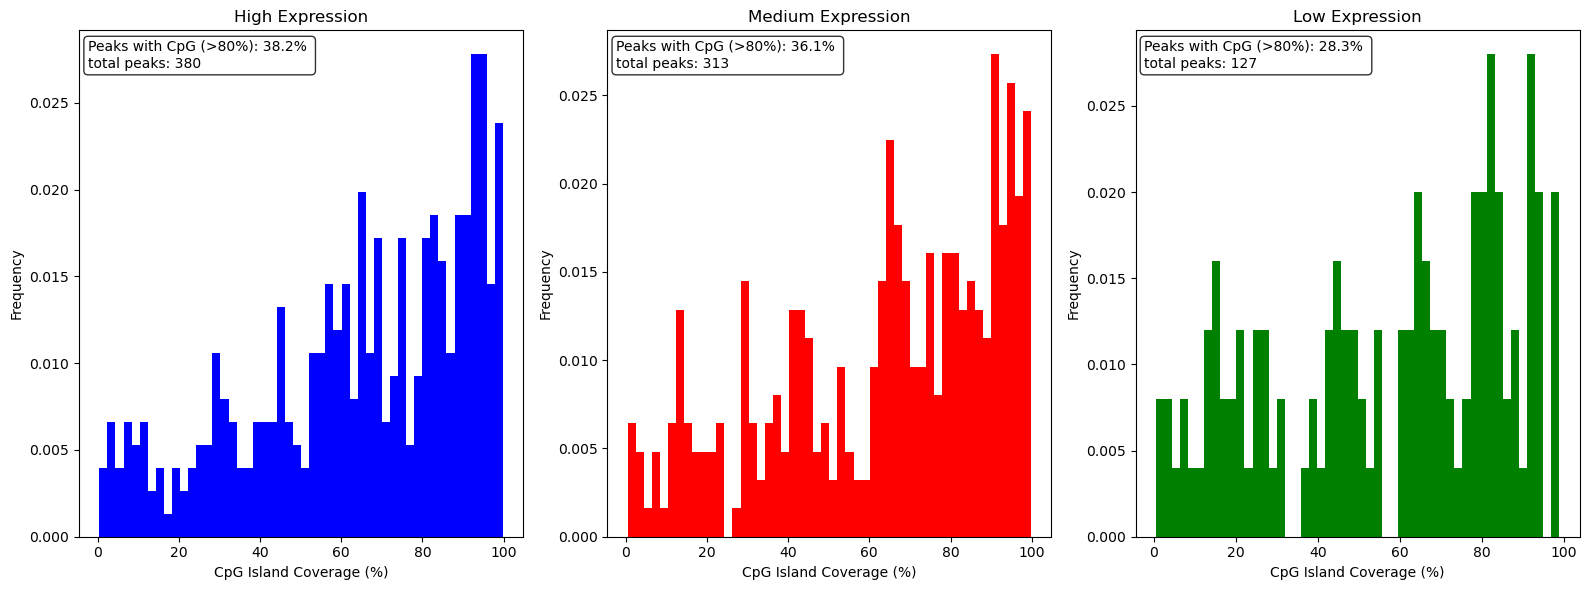

In [435]:
# Exogenous
fig = plot_coverage_histograms(exo_coverage_high, exo_coverage_medium, exo_coverage_low, min_coverage=0, p_t = 80)
plt.show()


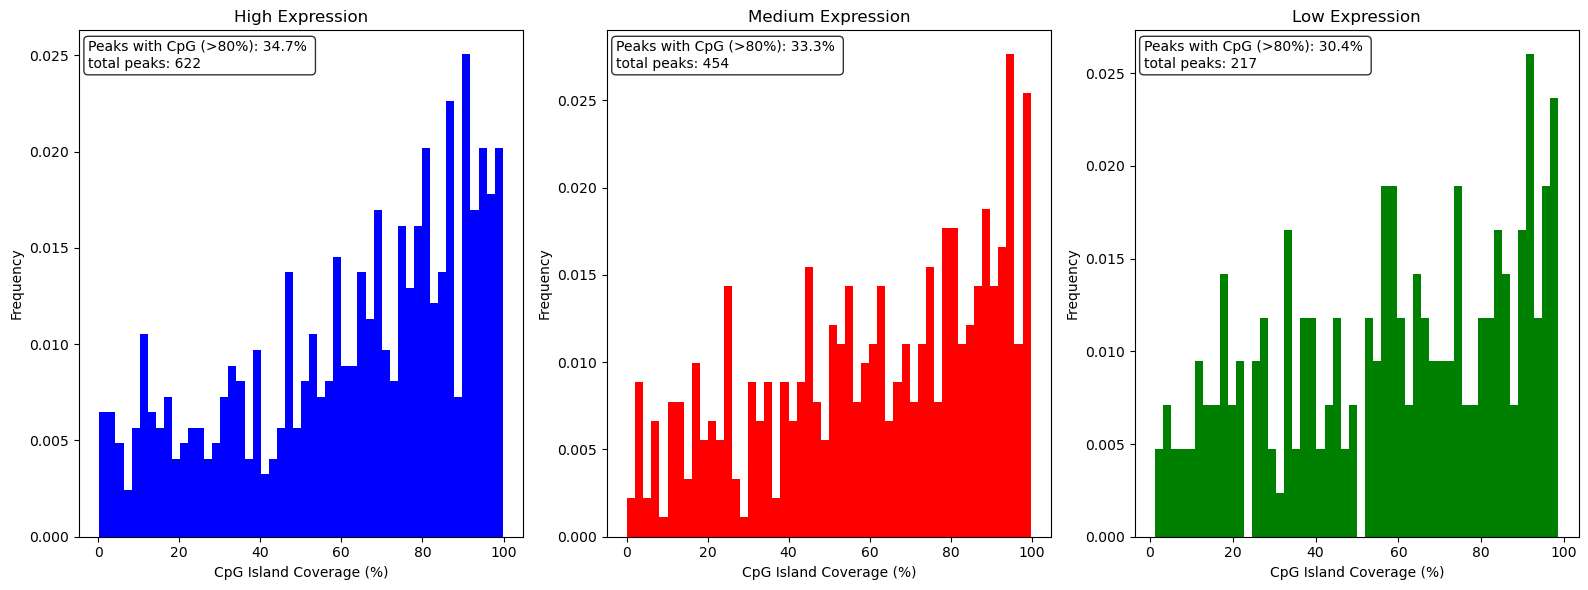

In [436]:
# Endogenous
fig = plot_coverage_histograms(endo_coverage_high, endo_coverage_medium, endo_coverage_low, min_coverage=0, p_t = 80)
plt.show()


# Down

In [437]:
DEA_NEU = pd.read_csv("./DATA/DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("./DATA/DEA_NSC.csv", header=0)

In [438]:
DEA_NEU = DEA_NEU[DEA_NEU['padj'] < 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['padj'] < 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['log2FoldChange'] < 0]
DEA_NEU = DEA_NEU[DEA_NEU['log2FoldChange'] < 0]

In [439]:
# Calculate quantiles for expression binning
q33, q66 = DEA_NSC['baseMean'].quantile([0.33, 0.66])

In [440]:
# Add expression level column to DEA_NSC
DEA_NSC['expression_level'] = DEA_NSC['baseMean'].apply(get_expression_level)

In [441]:
# Let's see the distribution
print("Expression level boundaries:")
print(f"Low: baseMean <= {q33:.2f}")
print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
print(f"High: baseMean > {q66:.2f}")
print("\nNumber of genes in each category:")
print(DEA_NSC['expression_level'].value_counts())

Expression level boundaries:
Low: baseMean <= 643.59
Medium: 643.59 < baseMean <= 1972.86
High: baseMean > 1972.86

Number of genes in each category:
expression_level
High      1592
Low       1546
Medium    1545
Name: count, dtype: int64


In [442]:
DEA_NSC_high = DEA_NSC[DEA_NSC.expression_level == 'High']
DEA_NSC_medium = DEA_NSC[DEA_NSC.expression_level == 'Medium']
DEA_NSC_low = DEA_NSC[DEA_NSC.expression_level == 'Low']

In [443]:
# Calculate coverage for filtered peaks
exo_coverage_high = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_medium = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_low = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

4 input query terms found dup hits:	[('Gm10736', 2), ('Rmrp', 2), ('6720427I07Rik', 2), ('2810025M15Rik', 2)]
85 input query terms found no hit:	['H2afy', '2610301B20Rik', 'Wrb', '4932438A13Rik', 'Impad1', 'AW549877', 'Yars', 'mt-Nd6', 'Dars', '


Converted 1507 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 1265/17536 peaks (7.2%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
4 input query terms found dup hits:	[('Gm10736', 2), ('Rmrp', 2), ('6720427I07Rik', 2), ('2810025M15Rik', 2)]
85 input query terms found no hit:	['H2afy', '2610301B20Rik', 'Wrb', '4932438A13Rik', 'Impad1', 'AW549877', 'Yars', 'mt-Nd6', 'Dars', '


Converted 1507 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 1569/21437 peaks (7.3%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
4 input query terms found dup hits:	[('Gm10736', 2), ('Rmrp', 2), ('6720427I07Rik', 2), ('2810025M15Rik', 2)]
85 input query terms found no hit:	['H2afy', '2610301B20Rik', 'Wrb', '4932438A13Rik', 'Impad1', 'AW549877', 'Yars', 'mt-Nd6', 'Dars', '


Converted 1507 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 1204/15676 peaks (7.7%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
11 input query terms found dup hits:	[('A130050O07Rik', 2), ('Gm20342', 2), ('Gm7964', 2), ('Scarna2', 2), ('D130019J16Rik', 2), ('261002
66 input query terms found no hit:	['Ttc30b', 'H2afy2', 'Fam45a', '1810058I24Rik', 'Tmem251', '1110051M20Rik', 'Rnf219', '2810004N23Rik


Converted 1479 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 1139/17536 peaks (6.5%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
11 input query terms found dup hits:	[('A130050O07Rik', 2), ('Gm20342', 2), ('Gm7964', 2), ('Scarna2', 2), ('D130019J16Rik', 2), ('261002
66 input query terms found no hit:	['Ttc30b', 'H2afy2', 'Fam45a', '1810058I24Rik', 'Tmem251', '1110051M20Rik', 'Rnf219', '2810004N23Rik


Converted 1479 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 1418/21437 peaks (6.6%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
11 input query terms found dup hits:	[('A130050O07Rik', 2), ('Gm20342', 2), ('Gm7964', 2), ('Scarna2', 2), ('D130019J16Rik', 2), ('261002
66 input query terms found no hit:	['Ttc30b', 'H2afy2', 'Fam45a', '1810058I24Rik', 'Tmem251', '1110051M20Rik', 'Rnf219', '2810004N23Rik


Converted 1479 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 1091/15676 peaks (7.0%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
126 input query terms found dup hits:	[('Gm7729', 2), ('Gm15421', 2), ('Gm9856', 2), ('Gm5900', 2), ('Gm8960', 2), ('B230323A14Rik', 2), (
78 input query terms found no hit:	['Ttc30a1', 'Gm24146', 'Rnu3a', '1700012D14Rik', 'Gm27804', 'Narfl', 'Smim4', 'Gm23973', 'Mettl7a1',


Converted 1465 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 910/17536 peaks (5.2%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
126 input query terms found dup hits:	[('Gm7729', 2), ('Gm15421', 2), ('Gm9856', 2), ('Gm5900', 2), ('Gm8960', 2), ('B230323A14Rik', 2), (
78 input query terms found no hit:	['Ttc30a1', 'Gm24146', 'Rnu3a', '1700012D14Rik', 'Gm27804', 'Narfl', 'Smim4', 'Gm23973', 'Mettl7a1',


Converted 1465 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 1103/21437 peaks (5.1%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
126 input query terms found dup hits:	[('Gm7729', 2), ('Gm15421', 2), ('Gm9856', 2), ('Gm5900', 2), ('Gm8960', 2), ('B230323A14Rik', 2), (
78 input query terms found no hit:	['Ttc30a1', 'Gm24146', 'Rnu3a', '1700012D14Rik', 'Gm27804', 'Narfl', 'Smim4', 'Gm23973', 'Mettl7a1',


Converted 1465 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 893/15676 peaks (5.7%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [444]:
# Calculate coverage for filtered peaks
endo_coverage_high = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_medium = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_low = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


4 input query terms found dup hits:	[('Gm10736', 2), ('Rmrp', 2), ('6720427I07Rik', 2), ('2810025M15Rik', 2)]
85 input query terms found no hit:	['H2afy', '2610301B20Rik', 'Wrb', '4932438A13Rik', 'Impad1', 'AW549877', 'Yars', 'mt-Nd6', 'Dars', '


Converted 1507 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 4221/68939 peaks (6.1%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
4 input query terms found dup hits:	[('Gm10736', 2), ('Rmrp', 2), ('6720427I07Rik', 2), ('2810025M15Rik', 2)]
85 input query terms found no hit:	['H2afy', '2610301B20Rik', 'Wrb', '4932438A13Rik', 'Impad1', 'AW549877', 'Yars', 'mt-Nd6', 'Dars', '


Converted 1507 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 2214/28061 peaks (7.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
4 input query terms found dup hits:	[('Gm10736', 2), ('Rmrp', 2), ('6720427I07Rik', 2), ('2810025M15Rik', 2)]
85 input query terms found no hit:	['H2afy', '2610301B20Rik', 'Wrb', '4932438A13Rik', 'Impad1', 'AW549877', 'Yars', 'mt-Nd6', 'Dars', '


Converted 1507 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 1577/19419 peaks (8.1%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
11 input query terms found dup hits:	[('A130050O07Rik', 2), ('Gm20342', 2), ('Gm7964', 2), ('Scarna2', 2), ('D130019J16Rik', 2), ('261002
66 input query terms found no hit:	['Ttc30b', 'H2afy2', 'Fam45a', '1810058I24Rik', 'Tmem251', '1110051M20Rik', 'Rnf219', '2810004N23Rik


Converted 1479 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 3740/68939 peaks (5.4%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
11 input query terms found dup hits:	[('A130050O07Rik', 2), ('Gm20342', 2), ('Gm7964', 2), ('Scarna2', 2), ('D130019J16Rik', 2), ('261002
66 input query terms found no hit:	['Ttc30b', 'H2afy2', 'Fam45a', '1810058I24Rik', 'Tmem251', '1110051M20Rik', 'Rnf219', '2810004N23Rik


Converted 1479 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 1901/28061 peaks (6.8%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
11 input query terms found dup hits:	[('A130050O07Rik', 2), ('Gm20342', 2), ('Gm7964', 2), ('Scarna2', 2), ('D130019J16Rik', 2), ('261002
66 input query terms found no hit:	['Ttc30b', 'H2afy2', 'Fam45a', '1810058I24Rik', 'Tmem251', '1110051M20Rik', 'Rnf219', '2810004N23Rik


Converted 1479 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 1365/19419 peaks (7.0%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
126 input query terms found dup hits:	[('Gm7729', 2), ('Gm15421', 2), ('Gm9856', 2), ('Gm5900', 2), ('Gm8960', 2), ('B230323A14Rik', 2), (
78 input query terms found no hit:	['Ttc30a1', 'Gm24146', 'Rnu3a', '1700012D14Rik', 'Gm27804', 'Narfl', 'Smim4', 'Gm23973', 'Mettl7a1',


Converted 1465 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 3179/68939 peaks (4.6%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
126 input query terms found dup hits:	[('Gm7729', 2), ('Gm15421', 2), ('Gm9856', 2), ('Gm5900', 2), ('Gm8960', 2), ('B230323A14Rik', 2), (
78 input query terms found no hit:	['Ttc30a1', 'Gm24146', 'Rnu3a', '1700012D14Rik', 'Gm27804', 'Narfl', 'Smim4', 'Gm23973', 'Mettl7a1',


Converted 1465 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 1487/28061 peaks (5.3%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
126 input query terms found dup hits:	[('Gm7729', 2), ('Gm15421', 2), ('Gm9856', 2), ('Gm5900', 2), ('Gm8960', 2), ('B230323A14Rik', 2), (
78 input query terms found no hit:	['Ttc30a1', 'Gm24146', 'Rnu3a', '1700012D14Rik', 'Gm27804', 'Narfl', 'Smim4', 'Gm23973', 'Mettl7a1',


Converted 1465 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 1069/19419 peaks (5.5%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


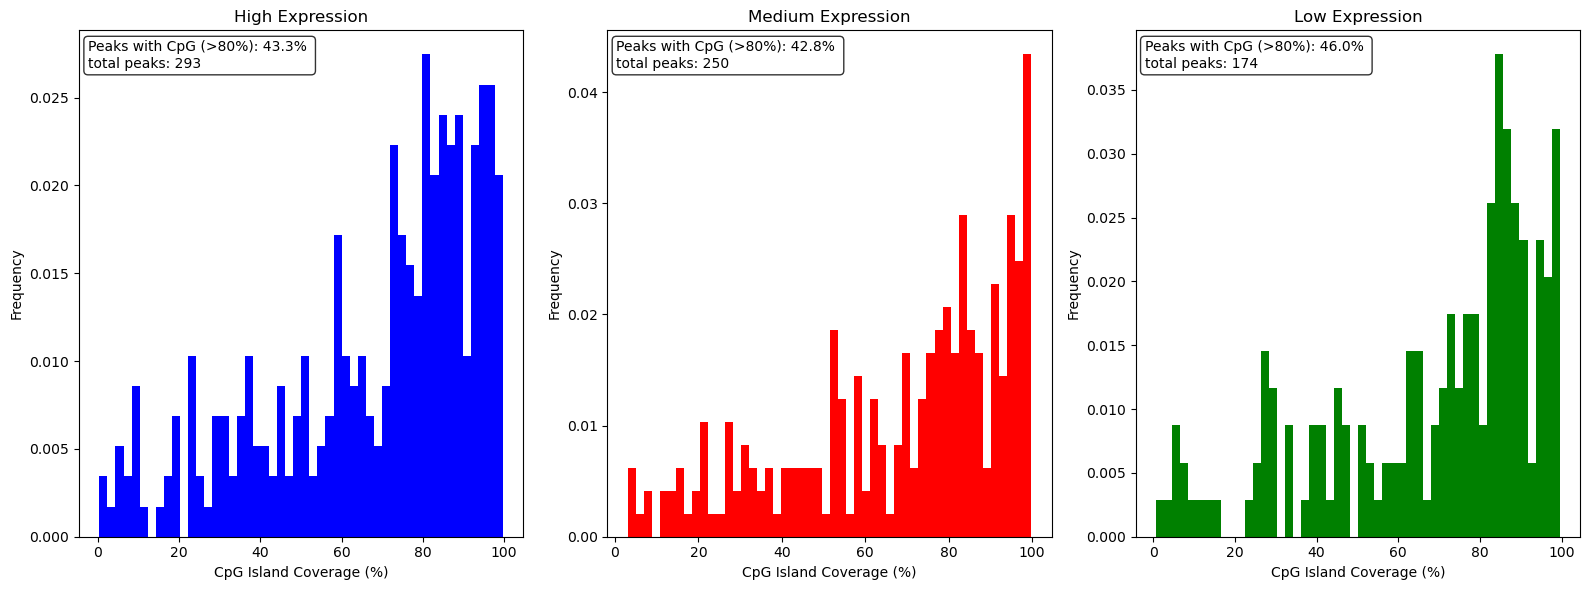

In [445]:
# Exogenous
fig = plot_coverage_histograms(exo_coverage_high, exo_coverage_medium, exo_coverage_low, min_coverage=0, p_t = 80)
plt.show()


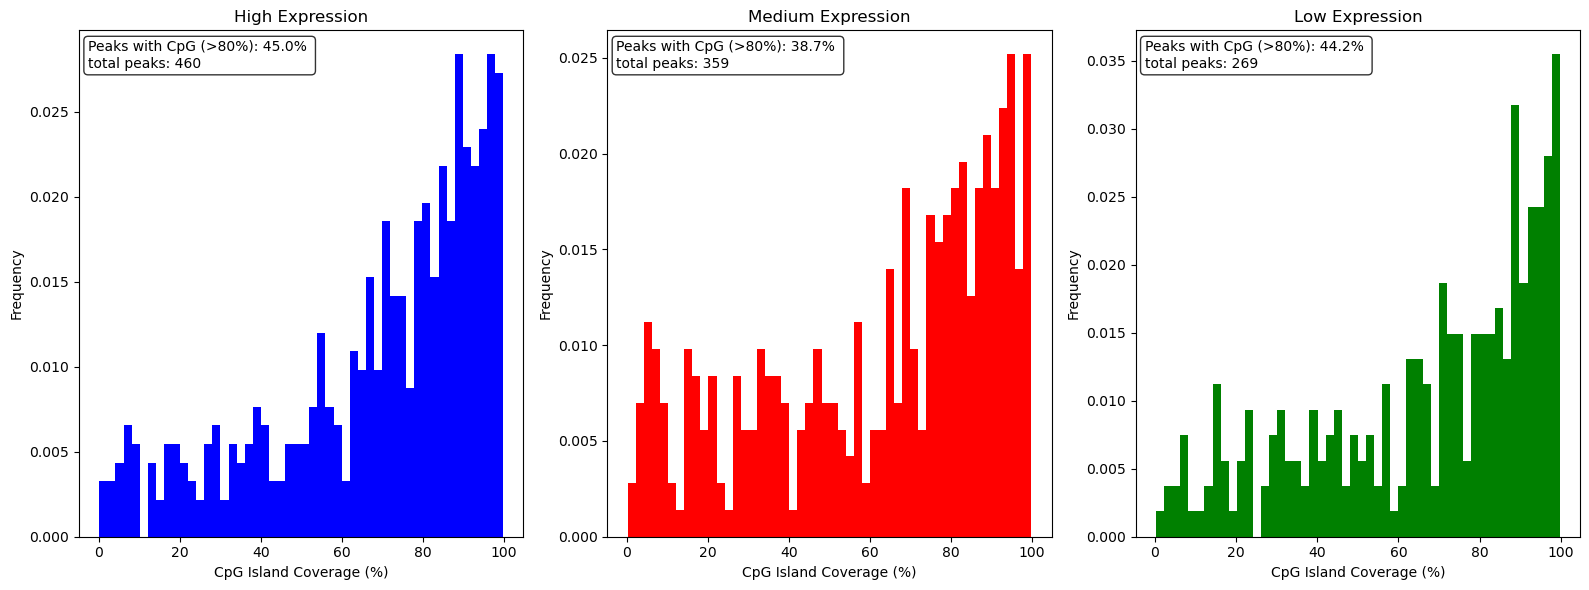

In [446]:
# Endogenous
fig = plot_coverage_histograms(endo_coverage_high, endo_coverage_medium, endo_coverage_low, min_coverage=0, p_t = 80)
plt.show()


# Not DE

In [447]:
DEA_NEU = pd.read_csv("./DATA/DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("./DATA/DEA_NSC.csv", header=0)

In [448]:
DEA_NEU = DEA_NEU[DEA_NEU['padj'] > 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['padj'] > 0.05]

In [449]:
# Calculate quantiles for expression binning
q33, q66 = DEA_NSC['baseMean'].quantile([0.33, 0.66])

In [450]:
# Add expression level column to DEA_NSC
DEA_NSC['expression_level'] = DEA_NSC['baseMean'].apply(get_expression_level)

In [451]:
# Let's see the distribution
print("Expression level boundaries:")
print(f"Low: baseMean <= {q33:.2f}")
print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
print(f"High: baseMean > {q66:.2f}")
print("\nNumber of genes in each category:")
print(DEA_NSC['expression_level'].value_counts())

Expression level boundaries:
Low: baseMean <= 142.40
Medium: 142.40 < baseMean <= 696.29
High: baseMean > 696.29

Number of genes in each category:
expression_level
High      1815
Low       1761
Medium    1761
Name: count, dtype: int64


In [452]:
DEA_NSC_high = DEA_NSC[DEA_NSC.expression_level == 'High']
DEA_NSC_medium = DEA_NSC[DEA_NSC.expression_level == 'Medium']
DEA_NSC_low = DEA_NSC[DEA_NSC.expression_level == 'Low']

In [453]:
# Calculate coverage for filtered peaks
exo_coverage_high = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_medium = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_low = []
for peak_file in exo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

9 input query terms found dup hits:	[('E130114P18Rik', 2), ('Bfar', 2), ('Gm10558', 2), ('4632415L05Rik', 2), ('2610005L07Rik', 2), ('Gm
46 input query terms found no hit:	['D1Ertd622e', 'Uhrf1bp1l', '3110039I08Rik', 'Fam49a', 'Gm23935', 'March2', 'Cyhr1', 'Mpp5', 'Gba', 


Converted 1767 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 1695/17536 peaks (9.7%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
9 input query terms found dup hits:	[('E130114P18Rik', 2), ('Bfar', 2), ('Gm10558', 2), ('4632415L05Rik', 2), ('2610005L07Rik', 2), ('Gm
46 input query terms found no hit:	['D1Ertd622e', 'Uhrf1bp1l', '3110039I08Rik', 'Fam49a', 'Gm23935', 'March2', 'Cyhr1', 'Mpp5', 'Gba', 


Converted 1767 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 2155/21437 peaks (10.1%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
9 input query terms found dup hits:	[('E130114P18Rik', 2), ('Bfar', 2), ('Gm10558', 2), ('4632415L05Rik', 2), ('2610005L07Rik', 2), ('Gm
46 input query terms found no hit:	['D1Ertd622e', 'Uhrf1bp1l', '3110039I08Rik', 'Fam49a', 'Gm23935', 'March2', 'Cyhr1', 'Mpp5', 'Gba', 


Converted 1767 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 1656/15676 peaks (10.6%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
99 input query terms found dup hits:	[('Gm40309', 2), ('Zfp939', 2), ('C79798', 2), ('Znf41-ps', 2), ('2610037D02Rik', 2), ('9530056E24Ri
90 input query terms found no hit:	['Ccpg1os', 'Ccdc130', 'Gm26699', 'Gm26518', 'Hist2h3c2', 'Gm26694', 'Gm26819', '3110001I22Rik', 'Gm


Converted 1665 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 1117/17536 peaks (6.4%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
99 input query terms found dup hits:	[('Gm40309', 2), ('Zfp939', 2), ('C79798', 2), ('Znf41-ps', 2), ('2610037D02Rik', 2), ('9530056E24Ri
90 input query terms found no hit:	['Ccpg1os', 'Ccdc130', 'Gm26699', 'Gm26518', 'Hist2h3c2', 'Gm26694', 'Gm26819', '3110001I22Rik', 'Gm


Converted 1665 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 1358/21437 peaks (6.3%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
99 input query terms found dup hits:	[('Gm40309', 2), ('Zfp939', 2), ('C79798', 2), ('Znf41-ps', 2), ('2610037D02Rik', 2), ('9530056E24Ri
90 input query terms found no hit:	['Ccpg1os', 'Ccdc130', 'Gm26699', 'Gm26518', 'Hist2h3c2', 'Gm26694', 'Gm26819', '3110001I22Rik', 'Gm


Converted 1665 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 1092/15676 peaks (7.0%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
325 input query terms found dup hits:	[('A530041M06Rik', 2), ('Dnmt3l-ps1', 2), ('Gm27042', 2), ('Gm13830', 2), ('Gm13204', 2), ('Gm28800'
96 input query terms found no hit:	['AC102333.1', 'Gm12609', 'Gm26530', 'AC132307.5', '2700046G09Rik', 'AC115752.1', 'Gm11146', 'D13005


Converted 1649 genes to Ensembl IDs
Filtered results/peaks/NSCv1_peaks.narrowPeak: kept 561/17536 peaks (3.2%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
325 input query terms found dup hits:	[('A530041M06Rik', 2), ('Dnmt3l-ps1', 2), ('Gm27042', 2), ('Gm13830', 2), ('Gm13204', 2), ('Gm28800'
96 input query terms found no hit:	['AC102333.1', 'Gm12609', 'Gm26530', 'AC132307.5', '2700046G09Rik', 'AC115752.1', 'Gm11146', 'D13005


Converted 1649 genes to Ensembl IDs
Filtered results/peaks/NSCv2_peaks.narrowPeak: kept 695/21437 peaks (3.2%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
325 input query terms found dup hits:	[('A530041M06Rik', 2), ('Dnmt3l-ps1', 2), ('Gm27042', 2), ('Gm13830', 2), ('Gm13204', 2), ('Gm28800'
96 input query terms found no hit:	['AC102333.1', 'Gm12609', 'Gm26530', 'AC132307.5', '2700046G09Rik', 'AC115752.1', 'Gm11146', 'D13005


Converted 1649 genes to Ensembl IDs
Filtered results/peaks/NSCv3_peaks.narrowPeak: kept 533/15676 peaks (3.4%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [454]:
# Calculate coverage for filtered peaks
endo_coverage_high = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_medium = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_low = []
for peak_file in endo_samples['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


9 input query terms found dup hits:	[('E130114P18Rik', 2), ('Bfar', 2), ('Gm10558', 2), ('4632415L05Rik', 2), ('2610005L07Rik', 2), ('Gm
46 input query terms found no hit:	['D1Ertd622e', 'Uhrf1bp1l', '3110039I08Rik', 'Fam49a', 'Gm23935', 'March2', 'Cyhr1', 'Mpp5', 'Gba', 


Converted 1767 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 6172/68939 peaks (9.0%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
9 input query terms found dup hits:	[('E130114P18Rik', 2), ('Bfar', 2), ('Gm10558', 2), ('4632415L05Rik', 2), ('2610005L07Rik', 2), ('Gm
46 input query terms found no hit:	['D1Ertd622e', 'Uhrf1bp1l', '3110039I08Rik', 'Fam49a', 'Gm23935', 'March2', 'Cyhr1', 'Mpp5', 'Gba', 


Converted 1767 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 2908/28061 peaks (10.4%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
9 input query terms found dup hits:	[('E130114P18Rik', 2), ('Bfar', 2), ('Gm10558', 2), ('4632415L05Rik', 2), ('2610005L07Rik', 2), ('Gm
46 input query terms found no hit:	['D1Ertd622e', 'Uhrf1bp1l', '3110039I08Rik', 'Fam49a', 'Gm23935', 'March2', 'Cyhr1', 'Mpp5', 'Gba', 


Converted 1767 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 2064/19419 peaks (10.6%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
99 input query terms found dup hits:	[('Gm40309', 2), ('Zfp939', 2), ('C79798', 2), ('Znf41-ps', 2), ('2610037D02Rik', 2), ('9530056E24Ri
90 input query terms found no hit:	['Ccpg1os', 'Ccdc130', 'Gm26699', 'Gm26518', 'Hist2h3c2', 'Gm26694', 'Gm26819', '3110001I22Rik', 'Gm


Converted 1665 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 3870/68939 peaks (5.6%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
99 input query terms found dup hits:	[('Gm40309', 2), ('Zfp939', 2), ('C79798', 2), ('Znf41-ps', 2), ('2610037D02Rik', 2), ('9530056E24Ri
90 input query terms found no hit:	['Ccpg1os', 'Ccdc130', 'Gm26699', 'Gm26518', 'Hist2h3c2', 'Gm26694', 'Gm26819', '3110001I22Rik', 'Gm


Converted 1665 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 1928/28061 peaks (6.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
99 input query terms found dup hits:	[('Gm40309', 2), ('Zfp939', 2), ('C79798', 2), ('Znf41-ps', 2), ('2610037D02Rik', 2), ('9530056E24Ri
90 input query terms found no hit:	['Ccpg1os', 'Ccdc130', 'Gm26699', 'Gm26518', 'Hist2h3c2', 'Gm26694', 'Gm26819', '3110001I22Rik', 'Gm


Converted 1665 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 1352/19419 peaks (7.0%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
325 input query terms found dup hits:	[('A530041M06Rik', 2), ('Dnmt3l-ps1', 2), ('Gm27042', 2), ('Gm13830', 2), ('Gm13204', 2), ('Gm28800'
96 input query terms found no hit:	['AC102333.1', 'Gm12609', 'Gm26530', 'AC132307.5', '2700046G09Rik', 'AC115752.1', 'Gm11146', 'D13005


Converted 1649 genes to Ensembl IDs
Filtered results/peaks/NSCM1_peaks.narrowPeak: kept 2061/68939 peaks (3.0%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
325 input query terms found dup hits:	[('A530041M06Rik', 2), ('Dnmt3l-ps1', 2), ('Gm27042', 2), ('Gm13830', 2), ('Gm13204', 2), ('Gm28800'
96 input query terms found no hit:	['AC102333.1', 'Gm12609', 'Gm26530', 'AC132307.5', '2700046G09Rik', 'AC115752.1', 'Gm11146', 'D13005


Converted 1649 genes to Ensembl IDs
Filtered results/peaks/NSCM2_peaks.narrowPeak: kept 980/28061 peaks (3.5%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
325 input query terms found dup hits:	[('A530041M06Rik', 2), ('Dnmt3l-ps1', 2), ('Gm27042', 2), ('Gm13830', 2), ('Gm13204', 2), ('Gm28800'
96 input query terms found no hit:	['AC102333.1', 'Gm12609', 'Gm26530', 'AC132307.5', '2700046G09Rik', 'AC115752.1', 'Gm11146', 'D13005


Converted 1649 genes to Ensembl IDs
Filtered results/peaks/NSCM3_peaks.narrowPeak: kept 704/19419 peaks (3.6%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


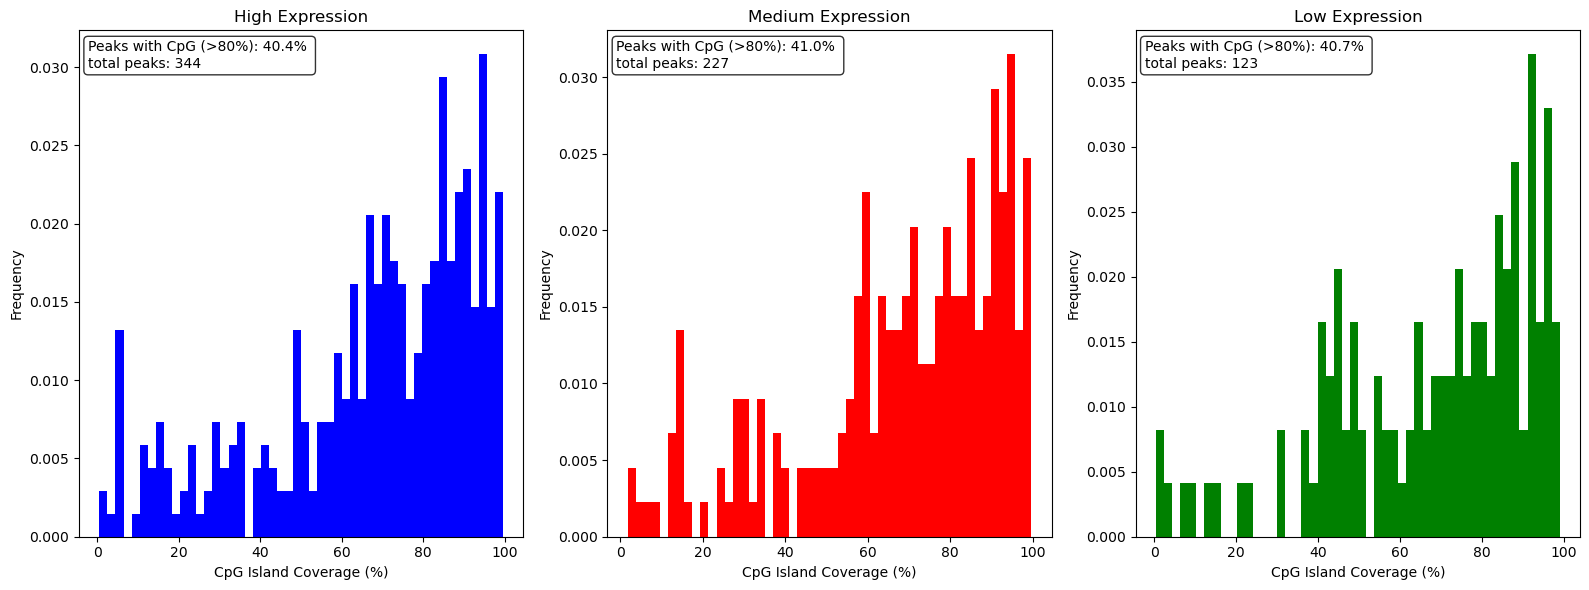

In [455]:
# Exogenous
fig = plot_coverage_histograms(exo_coverage_high, exo_coverage_medium, exo_coverage_low, min_coverage=0, p_t = 80)
plt.show()


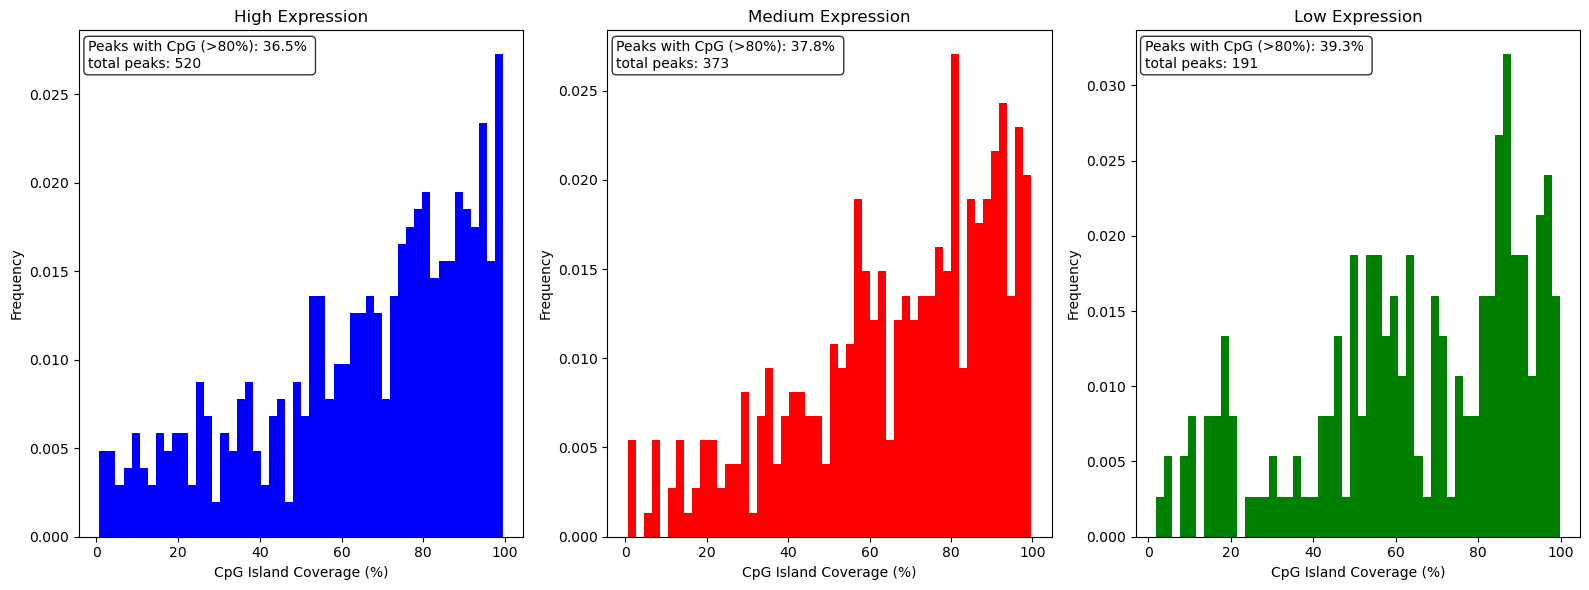

In [456]:
# Endogenous
fig = plot_coverage_histograms(endo_coverage_high, endo_coverage_medium, endo_coverage_low, min_coverage=0, p_t = 80)
plt.show()


# Plot peaks signals

In [241]:
import gzip
import numpy as np

def plot_peak_signals(peak_file, bigwig_files, window_size=1000, num_peaks=5):
    """
    Plot signal profiles for selected peaks across multiple bigWig files
    """
    import gzip  # Add this import at the top
    
    # Select random peaks
    cmd = f"shuf -n {num_peaks} {peak_file} > temp_random_peaks.bed"
    subprocess.run(cmd, shell=True)
    
    # Center peaks and extend by window_size
    half_window = window_size // 2
    signals = {}
    
    for bw_file in bigwig_files:
        # Use deepTools computeMatrix to get signal values
        matrix_file = "temp_matrix.gz"
        cmd = (f"computeMatrix reference-point"
               f" --referencePoint center"
               f" -b {half_window} -a {half_window}"
               f" -R temp_random_peaks.bed"
               f" -S {bw_file}"
               f" --skipZeros"
               f" -o {matrix_file}")
        
        # Run command and check for errors
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Error running computeMatrix for {bw_file}:")
            print(result.stderr)
            continue
            
        try:
            # Read the gzipped matrix
            data = []
            with gzip.open(matrix_file, 'rt') as f:
                for line in f:
                    if not line.startswith(('@', '#')):
                        values = line.strip().split('\t')[6:]  # Skip region info columns
                        data.append([float(x) for x in values])
            
            if data:  # Only store if we got some data
                signals[os.path.basename(bw_file)] = np.array(data)
            
        except Exception as e:
            print(f"Error processing matrix file for {bw_file}:")
            print(str(e))
            continue
        finally:
            # Clean up matrix file
            if os.path.exists(matrix_file):
                os.remove(matrix_file)
    
    if not signals:
        print("No valid signal data was obtained.")
        return
        
    # Create figure
    fig, axes = plt.subplots(num_peaks, 1, figsize=(10, 3*num_peaks))
    if num_peaks == 1:
        axes = [axes]
    
    # Create x-axis values (distance from center)
    bins = signals[list(signals.keys())[0]].shape[1]
    x = np.linspace(-half_window, half_window, bins)
    
    # Plot each peak
    for i in range(num_peaks):
        for bw_file, signal in signals.items():
            if i < len(signal):  # Make sure we have enough peaks
                axes[i].plot(x, signal[i], label=os.path.basename(bw_file))
                
        axes[i].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        axes[i].set_xlabel('Distance from peak center (bp)')
        axes[i].set_ylabel('Signal')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    # # Final cleanup
    # if os.path.exists("temp_random_peaks.bed"):
    #     os.remove("temp_random_peaks.bed")



In [242]:
# Get peaks for genes with both promoter types
filtered_peaks = get_common_peaks(exo_samples['Peaks'].iloc[0], common_genes, "DATA/genes.bed")

1 input query terms found no hit:	['Rnf165']


Converted 284 genes to Ensembl IDs
Filtered results/peaks/NeuV1_peaks.narrowPeak: kept 1701/56234 peaks (3.0%)


In [ ]:
# Use the function
bigwig_dir = "results/bigwig"
bigwig_files = [
    f"{bigwig_dir}/Exogenous_Neuron.bw",
    f"{bigwig_dir}/Endogenous_Neuron.bw"
]

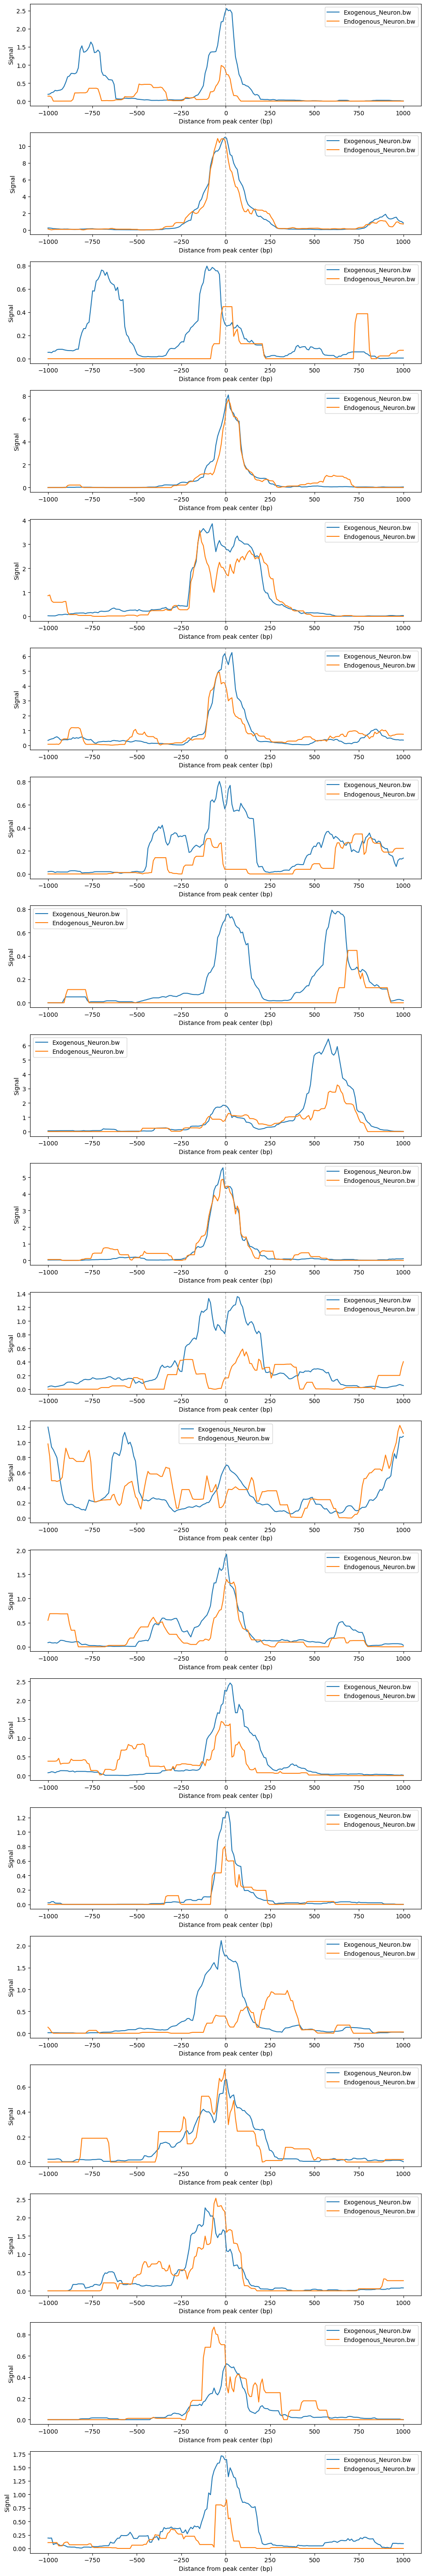

In [238]:
# Plot the signals
plot_peak_signals(filtered_peaks, bigwig_files, window_size=2000, num_peaks=20)